In [3]:
import sys
print(sys.version)

3.12.3 (main, Sep 11 2024, 14:17:37) [GCC 13.2.0]


In [18]:
#
# Load and extract the 327k bucket names downloaded from Grayhat Warfare
#
# The provided S3 names contain complete AWS domain information as well, which will be one of the following formats:
# 1) [bucket_name].s3.amazonaws.com
# 2) [bucket_name].s3-[aws_region].amazonaws.com
# 3) [bucket_name].s3.[aws_region].amazonaws.com
# 
#
import json, re

def extract_bucket_name(bucket_url):
    # Define regex pattern to match and capture the bucket name
    pattern = r"^(.+)?\.s3(?:[\.-])(.+)?amazonaws.com(?:\.[a-z]{2})?$"
    
    # Search for the pattern in the given URL
    match = re.match(pattern, bucket_url)
    
    # Return the bucket name if found, otherwise None
    return match.group(1) if match else None


with open('buckets.json', 'r') as f:
    gh_data = json.load(f)

bucket_names = [x['bucket'] for x in gh_data]
bucket_names = [extract_bucket_name(x) for x in bucket_names]
bucket_names = [b for b in bucket_names if b is not None]

# Save point, all bucket names minus the AWS domains
with open('parsed_buckets.json', 'w') as f:
    json.dump(bucket_names, f, indent=2)

In [139]:
#
# Let's attempt to tokenize
#
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

##
## Due to weird behavior, I ended up downloading *all* corpora and models to get the
## punkt tokenizer operational.
##
#nltk.download()

import json

with open('parsed_buckets.json') as f:
    buckets = json.load(f)

# Start with a simple Regex based tokenizer for the light work.
custom_tokenizer = RegexpTokenizer(r'\d+|[a-zA-Z]+')
tokenized_buckets = []
for b in buckets:
   tokenized_buckets.append(custom_tokenizer.tokenize(b.lower()))

from wordsegment import load, segment
load()
results = []
for bucket in tokenized_buckets:
    current_tokens = []
    for b in bucket:
       current_tokens.extend(segment(b))
    results.append(current_tokens)

with open("tokenized_buckets.json", "w") as f:
    json.dump(results, f, indent=2)
# print(results)


# print("compound" in english_words)
# from wordsegment import load, segment
# load()

    
# NOTE: Bert broke words based on tokens with no regard for the english dictionary
# Move on to a BERT based tokenizer to split words such as "websitecontent" and "siliconvalley"
# from transformers import BertTokenizer
# import torch
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# for bucket_tokens in tokenized_buckets[30:50]:
#     for token in bucket_tokens:
#         print(f"Input: {token}, output: {tokenizer.tokenize(token)}")
# print(tokenized_buckets[50:100])




In [134]:
# from wordfreq import top_n_list

# # Approx 235k English words, we need to remove single letters
# english_words = top_n_list("en", 10000)
# english_words = set([word for word in english_words if len(word) > 2])

# # print("\n".join(english_words))

# inputs = [
#     "compoundword",
#     "myscreenshots",
#     "screenshotlibrary",
#     "asdfbasdfdsaf",
#     "mygarbageghggfgfgf",
#     "resource3",
#     "legitimatedefensecontractor"
# ]

# def dictionary_split(input_word) -> list:
#     # print(f"Testing {input_word}")
#     splits = []
#     for i in range(1, len(input_word)-1):
#         prefix, suffix = input_word[:i], input_word[i:]

#         if english_words.issuperset({prefix, suffix}):
#             # Both words are a match, end it here
#             # print(f"Appending {prefix, suffix}")
#             splits.append([prefix, suffix])
#         elif prefix in english_words:
#             # We've matched a word based on the prefix. Recurse for the suffix, and
#             # add the combination as a contender
#             current_split = [prefix]
#             current_split.extend(dictionary_split(suffix))
#             splits.append(current_split)            
#         elif suffix in english_words:
#             # We've matched a word based on the suffix. Recurse for the suffix, and
#             # add the combination as a contender
#             current_split = dictionary_split(prefix)
#             current_split.append(suffix)
#             splits.append(current_split)
            
#     # After iteration, if splits is empty then return the full word.  Otherwise return the 
#     # Split with the least number of words
#     if len(splits) == 0:
#         return [input_word]
#     else:
#         min_splits = splits[0]
#         for test_split in splits:
#             if len(test_split) < len(min_splits):
#                 min_splits = test_split
#         return min_splits    

# # print("compound" in english_words)
# from wordsegment import load, segment
# load()


# for input in inputs:
#     print(segment(input))

['compound', 'word']
['my', 'screenshots']
['screenshot', 'library']
['asdfbasdfdsaf']
['my', 'garbage', 'ghg', 'gfg', 'fgf']
['resource', '3']
['legitimate', 'defense', 'contractor']


In [170]:
#
# Tag all bucket tokens with parts of speech with NLTK
# 
from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.tag import UnigramTagger


PHASE = ['alpha', 'beta', 'test']
INFRA = ['test', 'logs', 'download', 'staging', 'dev', 'www', 'web', 'cdn', 'images', 'blog', 'vpn', 'website', 'files',
         'files', 'app', 'public', 'scripts', 'static', 'git', 'devs', 'stats', 'db', 'wiki', 'aws', 'gcp', 'bucket',
         'temp', 'build', 'builds', 'downloads', 'log', 'backup', 'cassandra'
         'media', 'cache', 'screenshots', 'media', 'pics', 'android', 'cms', 'content', 'img', 'uploads', 'assets']
DEV = ['stack', 'src', 'repo', 'developer', 'playground', 'hash']
TLD = ['com', 'net', 'org', 'io', 'edu', 'uk','cn',]
with open("country_codes.json", 'r') as f:
    ccs = json.load(f)
CC = list(ccs.keys())


custom_terms = []
custom_terms.extend([(key, 'PHASE') for key in PHASE])
custom_terms.extend([(key, 'INFRA') for key in INFRA])
custom_terms.extend([(key, 'TLD') for key in TLD])
custom_terms.extend([(key, 'DEV') for key in DEV])
custom_terms.extend([(key.lower(), 'CC_TLD') for key in CC])

custom_terms = [custom_terms]

# print(custom_terms)

base_tagger = UnigramTagger(brown.tagged_sents(categories='news'))
tagger = UnigramTagger(custom_terms, backoff=base_tagger)

with open("tokenized_buckets.json", "r") as f:
    buckets = json.load(f)


tagged_buckets = [tagger.tag(bucket) for bucket in buckets]

with open("tagged_buckets.json", "w") as f:
    json.dump(tagged_buckets, f, indent=2)

# for bucket in buckets[:1000]:
#     print(tagger.tag(bucket))

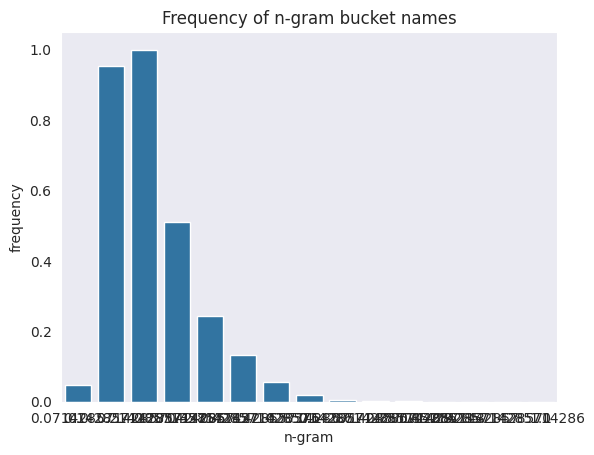

In [12]:
#
# Let's get some statistics on the n-gram tokens
#
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

n_grams = {}

with open("tagged_buckets.json", "r") as f:
    tagged_buckets = json.load(f)

for bucket_tags in tagged_buckets:
    tag_len = len(bucket_tags)
    count = n_grams.get(tag_len, 0)
    count = count + 1
    n_grams[tag_len] = count

# n-gram sizing, in n order
# for key, value in sorted(n_grams.items()):
#     print(key, ":", value)

#
# To prevent the long-tail from clogging up our view, filter out any n-grams with
# less than 50 count (out of 327,000)
#
filtered_n_grams = {key: value for key, value in n_grams.items() if value >= 50}

# Convert dictionary to DataFrame
df = pd.DataFrame(list(filtered_n_grams.items()), columns=["Key", "Value"])

# Sort the DataFrame by "Key" to match ascending key order
df = df.sort_values(by="Key")


# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to normalize all values in the DataFrame
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Plot the frequency with Seaborn
sns.set_style("dark")
sns.barplot(x="Key", y="Value", data=df)
plt.title("Frequency of n-gram bucket names")
plt.xlabel("n-gram")
plt.ylabel("frequency")
plt.show()


